In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


/tmp/ipykernel_26006/2851507980.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_01--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_disp = dir_project + info_basic['rdir_disp_pick']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
dir_image = dir_project + info_basic['rdir_image']
if not os.path.exists(dir_image):
    os.makedirs(dir_image)

In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [9]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [10]:
key_new = []
lon_centroid_higher = []
lat_centroid_higher = []
for key in key_subworks:
    ind = key_subworks.index(key)
    disp = np.loadtxt(dir_disp + 'ds_'+key+'curve.txt')
    modes = set(disp[:,2])
    if len(modes) > 1:
        key_new.append(key)
        lon_centroid_higher.append(lon_centroid_partition[ind])
        lat_centroid_higher.append(lat_centroid_partition[ind])

In [11]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

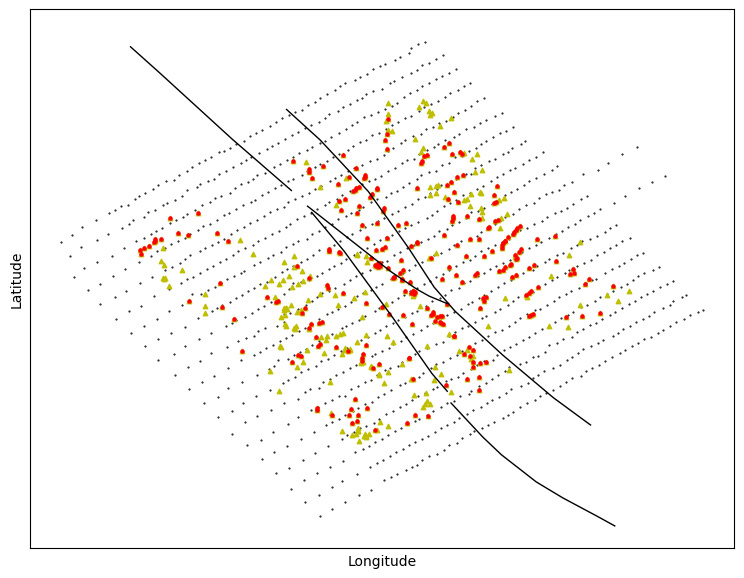

In [12]:
fig = plt.figure(figsize=(20, 7))
ax  = fig.add_subplot(121)
ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k',s=1)
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
flag_add = 0.0005
ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
for j in range(len(faults)):
    ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k',lw = 1)
ax.scatter(lon_centroid_partition,lat_centroid_partition,marker = '^',color = 'y',s = 10)
ax.scatter(lon_centroid_higher, lat_centroid_higher,marker='.',color='r',s=20)
plt.savefig(dir_image+'highermode_distribution.png')